In [62]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [63]:
# Wczytanie danych
df = pd.read_csv('final_dataset_SMOTE_balanced.csv')

In [64]:
# Konwersja kolumny Date z obsługą błędów oraz sortowanie według daty
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y', errors='coerce', dayfirst=True)
df = df.dropna(subset=['Date'])  # Usuwamy wiersze z niepoprawnymi datami
df = df.sort_values('Date')

In [65]:
# Przygotowanie danych:
# - FTR to wynik meczu (zmienna docelowa)
# - Usuwamy kolumny, które nie są dostępne przed rozpoczęciem meczu lub mogą powodować problemy:
#   "Unnamed: 0", "FTHG", "FTAG", "MW", "HTFormPtsStr", "ATFormPtsStr", "Date"
df_model = df.drop(columns=[ 'FTHG', 'FTAG', 'MW', 'HTFormPtsStr', 'ATFormPtsStr'])
y = df_model['FTR']
X = df_model.drop(columns=['FTR', 'Date'])


In [66]:
# Podział danych na zbiór treningowy i testowy oparty na czasie (80% najwcześniejszych, 20% najpóźniejszych)
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size].copy(), X.iloc[train_size:].copy()
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [67]:
# Przekształcenie etykiet na postać numeryczną
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [68]:
# Definicja cech kategorycznych i numerycznych
categorical_features = ['HomeTeam', 'AwayTeam']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

In [69]:
# Konwersja kolumn numerycznych do typu liczbowego (wartości niekonwertowalne stają się NaN)
for col in numerical_features:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

In [70]:
# Pipeline przetwarzania danych:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [71]:
# Budowa pipeline'u: preprocessing + XGBoost (XGBClassifier)
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        colsample_bytree=1.0,
        learning_rate=0.2,
        max_depth=20,
        n_estimators=400,
        subsample=1.0
    ))
])



In [72]:
# Trenowanie modelu
model.fit(X_train, y_train_enc)

C:\Users\dawid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [01:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HTGS', 'ATGS', 'HTGC',
                                                   'ATGC', 'HTP', 'ATP', 'HM1',
                                                   'HM2', 'HM3', 'HM4', 'HM5',
                                                   'AM1', 'AM2', 'AM3', 'AM4',
                                                   'AM5', 'HTFormPts',
                                                   'ATFormPts', 'HTWinStreak3',
                                                   'HTWinStreak5',
                                                   'HTLossStreak3',
                                                   'HTLossStreak5',
                                                   '...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=20, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [73]:
# Predykcja na zbiorze testowym
y_pred_enc = model.predict(X_test)

In [74]:
# Ocena modelu
y_pred_labels = le.inverse_transform(y_pred_enc)
accuracy = accuracy_score(y_test_enc, y_pred_enc)
print("Dokładność modelu XGBoost:", accuracy)
print("Raport klasyfikacji:\n", classification_report(y_test, y_pred_labels))

Dokładność modelu XGBoost: 0.6105160662122687
Raport klasyfikacji:
               precision    recall  f1-score   support

           A       0.64      0.55      0.59       345
           D       0.64      0.60      0.62       341
           H       0.57      0.68      0.62       341

    accuracy                           0.61      1027
   macro avg       0.61      0.61      0.61      1027
weighted avg       0.61      0.61      0.61      1027



,precision,recall,f1-score,support
H,0.64,0.55,0.59,345.00
D,0.64,0.60,0.62,341.00
A,0.57,0.68,0.62,341.00
accuracy,0.61,0.61,0.61,0.61
macro avg,0.61,0.61,0.61,1027.00
weighted avg,0.61,0.61,0.61,1027.00


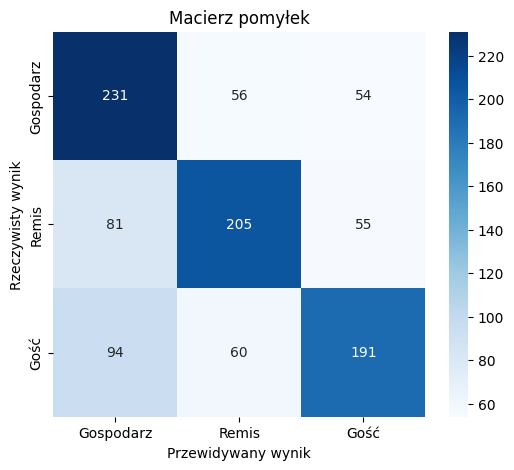

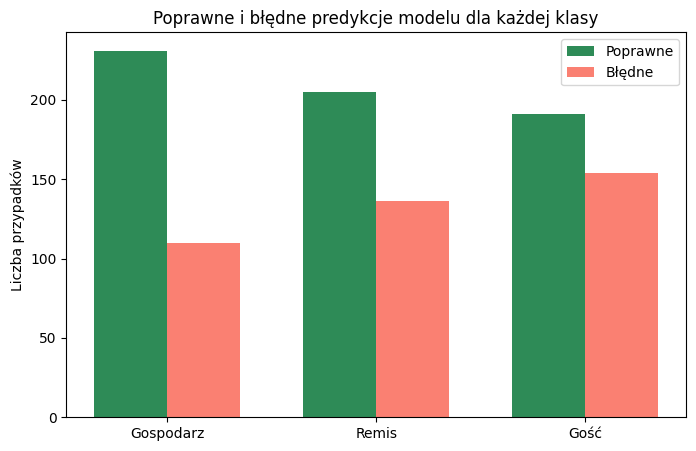

In [75]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Zakładamy że masz y_true i y_pred
report = classification_report(y_test, y_pred_labels, target_names=['H', 'D', 'A'], output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report.round(2))
from IPython.display import HTML

styled = df_report.style.background_gradient(cmap="Blues").format("{:.2f}")
HTML(styled.to_html())


from sklearn.metrics import confusion_matrix

# Oblicz macierz pomyłek
cm = confusion_matrix(y_test, y_pred_labels, labels=['H', 'D', 'A'])

# Etykiety klas
labels = ['Gospodarz', 'Remis', 'Gość']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Przewidywany wynik')
plt.ylabel('Rzeczywisty wynik')
plt.title('Macierz pomyłek')
plt.show()


import numpy as np

# Tworzymy DataFrame z prawdziwymi i przewidzianymi wynikami
results_df = pd.DataFrame({'Rzeczywisty': y_test, 'Predykowany': y_pred_labels})

# Dla każdej klasy policz trafienia i błędy
klasy = ['H', 'D', 'A']
etykiety = ['Gospodarz', 'Remis', 'Gość']
trafienia = []
pomyłki = []

for k in klasy:
    trafienia.append(np.sum((results_df['Rzeczywisty'] == k) & (results_df['Predykowany'] == k)))
    pomyłki.append(np.sum((results_df['Rzeczywisty'] == k) & (results_df['Predykowany'] != k)))

x = np.arange(len(klasy))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, trafienia, width, label='Poprawne', color='seagreen')
plt.bar(x + width/2, pomyłki, width, label='Błędne', color='salmon')
plt.xticks(x, etykiety)
plt.ylabel('Liczba przypadków')
plt.title('Poprawne i błędne predykcje modelu dla każdej klasy')
plt.legend()
plt.show()

In [76]:
from IPython.display import HTML

styled = df_report.style.background_gradient(cmap="Blues").format("{:.2f}")
HTML(styled.to_html())

,precision,recall,f1-score,support
H,0.64,0.55,0.59,345.00
D,0.64,0.60,0.62,341.00
A,0.57,0.68,0.62,341.00
accuracy,0.61,0.61,0.61,0.61
macro avg,0.61,0.61,0.61,1027.00
weighted avg,0.61,0.61,0.61,1027.00


In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Lżejsza siatka hiperparametrów do XGBoost
#param_grid = {
    'classifier__n_estimators': [400],
    'classifier__max_depth': [5,6,7,8,9,10],
    'classifier__learning_rate': [0.1, 0.2, 0.3],
    'classifier__subsample': [1.0,1.2,1.5],
    'classifier__gamma': [0, 0.1, 0.2],
    'classifier__colsample_bytree': [1.0]
}
# GridSearchCV na pipeline
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Dopasowanie do danych treningowych
grid_search.fit(X_train, y_train_enc)

# Najlepsze parametry i wynik walidacji
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik walidacji (accuracy):", grid_search.best_score_)

# Predykcja i ewaluacja na zbiorze testowym
y_pred_enc = grid_search.best_estimator_.predict(X_test)
y_pred_enc = le.inverse_transform(y_pred_enc)

# Raport klasyfikacji
print("Raport klasyfikacji na zbiorze testowym:")
print(classification_report(y_test, y_pred_enc))


IndentationError: unexpected indent (3683784401.py, line 7)